In [ ]:
# def process_data(input_file, output_file):
#     with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
#         for line in infile:
#             # Split the line into its components
#             parts = line.strip().split(',')
            
#             # Check if we have at least 5 parts (file path + 4 features)
#             if len(parts) >= 5:
#                 # Replace 'None' with 'mixed' in the 4th column (3rd feature)
#                 if parts[3] == 'None':
#                     parts[3] = 'mixed'
                
#                 # Replace 'None' with 'unknown' in other columns
#                 for i in range(1, len(parts)):
#                     if i != 3 and parts[i] == 'None':
#                         parts[i] = 'unknown'
            
#             # Join the parts back into a line and write to output file
#             outfile.write(','.join(parts) + '\n')

# # Usage
# input_file = '/home/zakaria/workspace/ai-photo-enhancer/dataset/categories.txt'
# output_file = 'processed_data.txt'
# process_data(input_file, output_file)

In [1]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.v2.functional as F
import random
import os
from pathlib import Path



# torch.inference_mode():
class FiveKDataset(Dataset):
    """
    A dataset that reads Adobe5K dataset images
    output : tensor of unprocessed images
    """
    def __init__(self, image_size,mode="train", resize= True,augment_data=True):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset", "FiveK")
        
        if mode =='train':
            self.IMGS_PATH = os.path.join(dataset_dir, "train")
        else:
            self.IMGS_PATH = os.path.join(dataset_dir, "test")
        self.resize= resize
        self.image_size =image_size
        self.augment_data = augment_data
        self.img_files = [filename for filename in os.listdir(self.IMGS_PATH+'/input/')]

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self,idx):
        source_path = self.img_files[idx]

        source = read_image(self.IMGS_PATH+'/input/'+source_path)
        target = read_image(self.IMGS_PATH+'/target/'+source_path)
        if self.resize:
            source =  F.resize(source,(self.image_size,self.image_size), interpolation= F.InterpolationMode.BICUBIC)
            target =  F.resize(target,(self.image_size,self.image_size), interpolation= F.InterpolationMode.BICUBIC)
            
        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)
            
        # source = self.transform(Image.open(ORIGINAL_FOLDER+source_path))

        return source, target


In [21]:
from transformers import BertTokenizer, BertModel

class FiveKDataset(Dataset):
    """
    A dataset that reads Adobe5K dataset images and associated semantic features.
    Output: tensor of unprocessed images and text embedded semantic features.
    """
    def __init__(self, image_size, feature_file, mode="train", resize=True, augment_data=True):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset", "FiveK")
        
        if mode =='train':
            self.IMGS_PATH = os.path.join(dataset_dir, "train")
        else:
            self.IMGS_PATH = os.path.join(dataset_dir, "test")
            
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.img_files = [filename for filename in os.listdir(self.IMGS_PATH+'/input/')]
        
        # Load BERT model and tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')
        
        # Load and process the feature file
        self.feature_dict = self._load_and_process_features(feature_file)
    
    def _load_and_process_features(self, feature_file):
        feature_dict = {}
        
        with open(feature_file, 'r') as file:
            for line in file:
                parts = line.strip().split(',')
                img_name = parts[0]
                features = parts[1:]
                feature_dict[img_name] = features
        
        return feature_dict

    def get_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', padding=True, truncation=True)
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze()

    def __len__(self):
        return len(self.img_files)
    
    def __getitem__(self, idx):
        source_path = self.img_files[idx]

        source = read_image(self.IMGS_PATH + '/input/' + source_path)
        target = read_image(self.IMGS_PATH + '/target/' + source_path)
        
        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            
        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)
        
        # Get the embedded features for the image
        features = ' '.join(self.feature_dict[source_path.split('.')[0]])
        embedded_features = self.get_embedding(features)
        
        return source, target, embedded_features


In [22]:
a=FiveKDataset(64,'/home/zakaria/workspace/ai-photo-enhancer/dataset/processed_categories.txt')

In [10]:
a.feature_dict

{'a0001-jmac_DSC1459': ['outdoor', 'day', 'sun_sky', 'nature'],
 'a0002-dgw_005': ['indoor', 'day', 'mixed', 'people'],
 'a0003-NKIM_MG_8178': ['outdoor', 'day', 'sun_sky', 'man_made'],
 'a0004-jmac_MG_1384': ['outdoor', 'day', 'sun_sky', 'nature'],
 'a0005-jn_2007_05_10__564': ['outdoor', 'day', 'sun_sky', 'man_made'],
 'a0006-IMG_2787': ['outdoor', 'day', 'sun_sky', 'animals'],
 'a0007-IMG_2480': ['outdoor', 'day', 'sun_sky', 'man_made'],
 'a0008-WP_CRW_3959': ['indoor', 'unknown', 'artificial', 'people'],
 'a0009-kme_372': ['indoor', 'day', 'mixed', 'unknown'],
 'a0010-jmac_MG_4807': ['outdoor', 'day', 'sun_sky', 'nature'],
 'a0011-DSC_0082': ['outdoor', 'day', 'sun_sky', 'nature'],
 'a0012-kme_143': ['outdoor', 'day', 'sun_sky', 'man_made'],
 'a0013-MB_20030906_001': ['outdoor', 'day', 'sun_sky', 'people'],
 'a0014-WP_CRW_6320': ['outdoor', 'day', 'sun_sky', 'animals'],
 'a0015-DSC_0081': ['outdoor', 'day', 'sun_sky', 'people'],
 'a0016-jmac_MG_0795': ['outdoor', 'day', 'sun_sky', 

In [32]:
a[0][2]

tensor([ 4.1347e-01,  8.8708e-02,  1.5672e-01,  4.9557e-02,  3.6381e-01,
        -1.5964e-01,  4.3800e-01,  5.3342e-01, -1.8656e-02, -6.5628e-01,
         7.0651e-02, -1.3613e-01, -3.3698e-01,  3.8377e-01,  7.1937e-02,
         3.6806e-01, -6.9049e-02,  2.8902e-01,  1.0946e-01,  1.5248e-01,
         1.8796e-01, -2.2338e-01,  1.3579e-01, -1.2106e-01,  4.7769e-01,
        -1.8883e-02, -8.8114e-02,  3.0059e-01, -2.5489e-01,  9.6725e-03,
        -1.4720e-02,  3.1650e-02,  1.7530e-02,  6.6680e-02,  1.1486e-01,
        -2.5672e-01, -1.7123e-01, -1.9405e-01, -2.7149e-03,  4.3409e-01,
        -1.8523e-01, -7.1232e-01,  1.2774e-01,  5.7116e-02,  2.6271e-02,
        -2.0616e-01, -4.1619e-01,  4.5283e-01,  1.3965e-01,  8.6288e-02,
        -2.0696e-01,  3.1830e-01, -2.9253e-02,  2.5034e-01,  1.8568e-01,
         5.9159e-01,  3.4158e-01, -1.7963e-01, -6.6989e-02, -7.2590e-02,
         3.4261e-01,  1.3371e-02, -2.6536e-01, -2.6029e-01, -4.1932e-02,
         2.6994e-02, -1.1507e-01, -2.4100e-01, -2.4

In [61]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from transformers import BertTokenizer, BertModel

class FiveKDataset(Dataset):
    """
    A dataset that reads Adobe5K dataset images and semantic features
    output: tensor of unprocessed images and optionally text features
    """
    def __init__(self, image_size, mode="train", resize=True, augment_data=True, use_txt_features=False):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        # Load image files and semantic features
        self.img_files = []
        self.features = {}
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                self.features[img_name] = parts[1:]
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input')) if f in self.features]
        
        # Create feature dictionaries
        self.feature_categories = {
            'location': ['outdoor', 'indoor', 'unknown'],
            'time': ['day', 'night', 'unknown'],
            'lighting': ['sun_sky', 'artificial', 'mixed', 'unknown'],
            'content': ['people', 'nature', 'man_made', 'animals', 'unknown']
        }
        
        # Create one-hot encoding maps
        self.one_hot_maps = {category: {value: i for i, value in enumerate(values)}
                             for category, values in self.feature_categories.items()}

        # Initialize BERT model and tokenizer for embedded features
        if self.use_txt_features == "embedded":
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.bert_model = BertModel.from_pretrained('bert-base-uncased')

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features
            one_hot_features = []
            for category, feature in zip(self.feature_categories.keys(), self.features[img_name]):
                one_hot = [0] * len(self.feature_categories[category])
                one_hot[self.one_hot_maps[category].get(feature, -1)] = 1
                one_hot_features.extend(one_hot)

            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "embedded":
            # Create text representation of features
            text_features = " ".join(self.features[img_name])
            
            # Tokenize and get BERT embeddings
            inputs = self.tokenizer(text_features, return_tensors="pt", padding=True, truncation=True, max_length=512)
            with torch.no_grad():
                outputs = self.bert_model(**inputs)
            
            # Use the [CLS] token embedding as the feature representation
            embedded_features = outputs.last_hidden_state[:, 0, :].squeeze()
            
            return source, embedded_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot', or 'embedded'.")

In [62]:
a =FiveKDataset(64,use_txt_features='one_hot')

In [65]:
a[0][1]

tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.])

In [102]:
import os
from pathlib import Path
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms.functional as F
import random
import torch
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

class FiveKDataset(Dataset):
    def __init__(self, image_size, mode="train", resize=True, augment_data=True, use_txt_features=False):
        current_dir = os.getcwd()
        dataset_dir = os.path.join(current_dir, "..", "dataset")
        self.IMGS_PATH = os.path.join(dataset_dir, f"FiveK/{mode}")
        self.FEATURES_PATH = os.path.join(dataset_dir, "processed_categories.txt")
        
        self.resize = resize
        self.image_size = image_size
        self.augment_data = augment_data
        self.use_txt_features = use_txt_features
        
        self.img_files = []
        self.features = {}
        self.feature_categories = ["Location", "Time", "Light", "Subject"]
        
        # Load semantic features from processed_categories.txt
        with open(self.FEATURES_PATH, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                img_name = parts[0]
                img_features = parts[1:]
                self.features[img_name] = img_features
        
        # Load image files
        self.img_files = [f for f in os.listdir(os.path.join(self.IMGS_PATH, 'input'))]
        
        # Prepare MultiLabelBinarizer
        all_features = [self.features[img] for img in self.img_files]
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_features)
        
        # Create encoding dictionaries for categorical approach
        unique_features = {cat: set(feat[i] for feat in all_features) for i, cat in enumerate(self.feature_categories)}
        self.feature_to_idx = {
            cat: {feat: idx for idx, feat in enumerate(sorted(features))}
            for cat, features in unique_features.items()
        }

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        source = read_image(os.path.join(self.IMGS_PATH, 'input', img_name))
        target = read_image(os.path.join(self.IMGS_PATH, 'target', img_name))

        if self.resize:
            source = F.resize(source, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)
            target = F.resize(target, (self.image_size, self.image_size), interpolation=F.InterpolationMode.BICUBIC)

        if self.augment_data:
            if random.random() > 0.5:
                source = F.hflip(source)
                target = F.hflip(target)
            if random.random() > 0.5:
                source = F.vflip(source)
                target = F.vflip(target)

        if not self.use_txt_features:
            return source, target

        elif self.use_txt_features == "one_hot":
            # One-hot encode the features using MultiLabelBinarizer
            one_hot_features = self.mlb.transform([self.features[img_name]])[0]
            one_hot_features = torch.tensor(one_hot_features, dtype=torch.float32)
            return source, one_hot_features, target

        elif self.use_txt_features == "categorical":
            # Return categorical indices
            cat_features = [self.feature_to_idx[cat][feat] for cat, feat in zip(self.feature_categories, self.features[img_name])]
            cat_features = torch.tensor(cat_features, dtype=torch.long)
            return source, cat_features, target

        else:
            raise ValueError("Invalid value for use_txt_features. Must be False, 'one_hot' or 'categorical'.")

    def collate_fn(self, batch):
        sources, features, targets = zip(*batch)
        sources = torch.stack(sources)
        targets = torch.stack(targets)
        
        if self.use_txt_features in ["one_hot", "categorical"]:
            features = torch.stack(features)
        else:
            features = None

        return sources, features, targets

In [116]:
from torch.utils.data import DataLoader

a =FiveKDataset(244,use_txt_features='one_hot')
d = DataLoader(a, batch_size=32 , shuffle = True)

In [104]:
for i,j,k in d:
    
    break

torch.Size([32, 14])


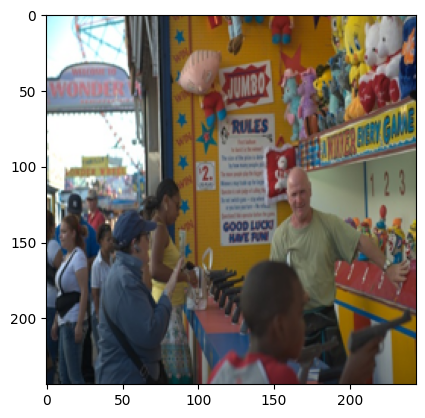

In [117]:
import matplotlib.pyplot as plt

plt.imshow(a[0][0].permute(1,2,0))

In [76]:
a.feature_to_idx

{'Location': {'indoor': 0, 'outdoor': 1, 'unknown': 2},
 'Time': {'day': 0, 'dusk': 1, 'night': 2, 'unknown': 3},
 'Light': {'artificial': 0, 'mixed': 1, 'sun_sky': 2},
 'Subject': {'abstract': 0,
  'animals': 1,
  'man_made': 2,
  'nature': 3,
  'people': 4,
  'unknown': 5}}

In [75]:
a.features['a0001-jmac_DSC1459.jpg']

['outdoor', 'day', 'sun_sky', 'nature']

In [77]:
a.img_files


['a0261-_DSC2228.jpg',
 'a3403-Ja_Pe-35.jpg',
 'a1485-dvf_042.jpg',
 'a4236-DSC_0384.jpg',
 'a2297-dvf_085.jpg',
 'a4376-_DSC0106.jpg',
 'a2908-20050225_075006__E6B9762.jpg',
 'a2692-060824_103042__MG_6710.jpg',
 'a1806-kme_342.jpg',
 'a0239-_MG_1622.jpg',
 'a0586-JI2E4687.jpg',
 'a2055-IMG_4247.jpg',
 'a2808-20080516_072208__MG_0018.jpg',
 'a2164-kme_171.jpg',
 'a1183-07-07-01-at-11h01m48s-_MG_2035.jpg',
 'a1729-tc_DSC1717.jpg',
 'a4006-jn_20080524_020.jpg',
 'a0559-_DSC0007-2.jpg',
 'a3302-kme_606.jpg',
 'a1791-kme_331.jpg',
 'a2911-Ja_Pe-18.jpg',
 'a1225-_DSC0019-2.jpg',
 'a0512-_MG_1623.jpg',
 'a0807-DSC_0026.jpg',
 'a0679-kme_284.jpg',
 'a2276-KE_-2382.jpg',
 'a3084-kme_076.jpg',
 'a4075-JI2E0444.jpg',
 'a3002-MB_060708_203.jpg',
 'a2325-jn_2007_12_15__BU_CRUISE_237.jpg',
 'a0329-_MG_1830.jpg',
 'a0040-_DSC5693.jpg',
 'a1074-IMG_4958.jpg',
 'a3432-jmac_DSC3184.jpg',
 'a3358-kme_273.jpg',
 'a2268-_DGW6411.jpg',
 'a0272-050703_183414__I2E9359.jpg',
 'a3619-MB_20041016_5.jpg',
 'a181

In [67]:
a[0][1]

['outdoor', 'day', 'sun_sky', 'people']
[0 0 0 1 0 0 0 0 0 0 1 1 1 0]


tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

In [52]:
a.mlb.classes_

array(['abstract', 'animals', 'artificial', 'day', 'dusk', 'indoor',
       'man_made', 'mixed', 'nature', 'night', 'outdoor', 'people',
       'sun_sky', 'unknown'], dtype=object)

In [78]:
a.img_files[0]

'a0261-_DSC2228.jpg'

In [47]:
a[0][1]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])

In [64]:
torch.tensor(a.mlb.transform([['outdoor', 'day', 'sun_sky', 'nature']])[0])

tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0])

In [30]:
a[0][1]

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])